In [1]:
import os
import pickle
import glob
import sys
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

# user path:
usrname = getpass.getuser()
# add paths:
sys.path.append(f'/Users/{usrname}/Desktop/Projects')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/bimanual_wrist')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/Functional_Fusion')
sys.path.append(f'/Users/{usrname}/Desktop/Projects/PcmPy')


import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# Load dataset

============== M1 ==============
Mean Pearson r: 0.042 +/- 0.020
T-test > 0: t(23) = 2.090, p = 2.3928e-02


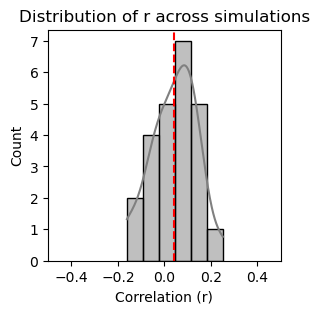

============== S1 ==============
Mean Pearson r: 0.027 +/- 0.017
T-test > 0: t(23) = 1.623, p = 5.9063e-02


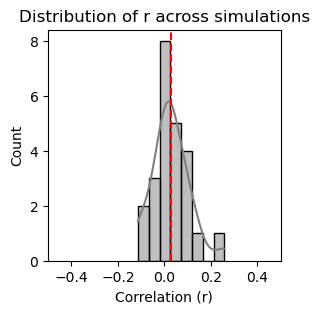

============== PMd ==============
Mean Pearson r: 0.087 +/- 0.020
T-test > 0: t(23) = 4.372, p = 1.1137e-04


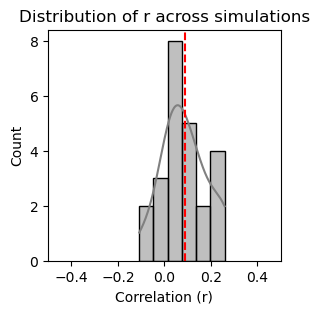

============== PMv ==============
Mean Pearson r: 0.062 +/- 0.024
T-test > 0: t(23) = 2.587, p = 8.2482e-03


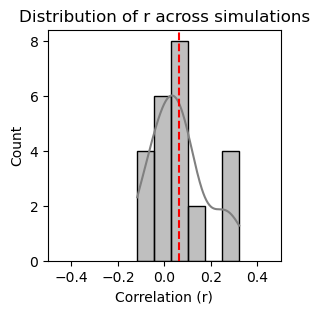

============== SMA ==============
Mean Pearson r: 0.070 +/- 0.011
T-test > 0: t(23) = 6.477, p = 6.5540e-07


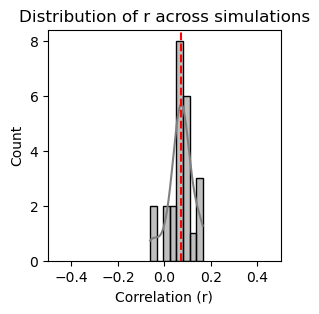

============== SPLa ==============
Mean Pearson r: 0.077 +/- 0.018
T-test > 0: t(23) = 4.350, p = 1.1759e-04


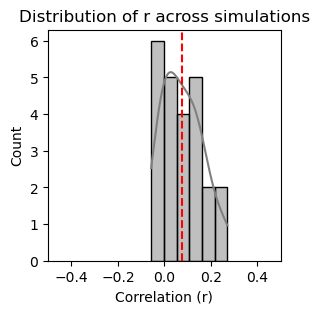

============== SPLp ==============
Mean Pearson r: 0.081 +/- 0.023
T-test > 0: t(23) = 3.577, p = 7.9859e-04


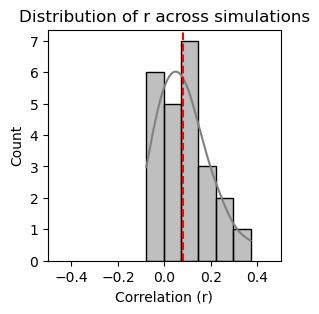

============== V1 ==============
Mean Pearson r: 0.090 +/- 0.018
T-test > 0: t(23) = 4.891, p = 3.0561e-05


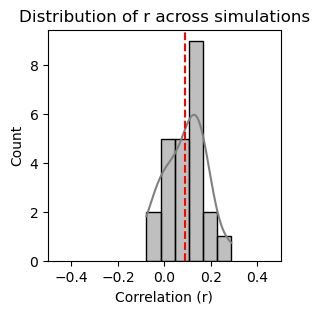

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

    # load pcm dataset:
    D = np.load(datafile, allow_pickle=True)
    Y = D['Y']
    
    N = len(Y)
    r = []
    for i in range(N):
        measurements = Y[i].measurements
        cond_vec = Y[i].obs_descriptors['cond_vec']
        num_voxels = measurements.shape[1]
        ncond = 12

        # Create an array to store the averaged patterns for each condition
        averaged_patterns = np.zeros((ncond, num_voxels))

        # Loop through each condition and calculate the average pattern
        for c in range(ncond):
            # Find rows corresponding to the current condition
            condition_indices = cond_vec == c
            # Calculate the mean pattern for the current condition
            averaged_patterns[c, :] = measurements[condition_indices, :].mean(axis=0)

        # get the contra conditions: 
        y_contra_avg = averaged_patterns[0:6, :]
        # remove mean across conditions:
        y_contra_avg = y_contra_avg - y_contra_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_contra_vec = y_contra_avg.flatten()
        
        # get the ipsi conditions:
        y_ipsi_avg = averaged_patterns[6:12, :]
        # remove mean across conditions:
        y_ipsi_avg = y_ipsi_avg - y_ipsi_avg.mean(axis=0)
        # flatten the averaged patterns:
        y_ipsi_vec = y_ipsi_avg.flatten()

        # concatenate the contra and ipsi patterns:
        r.append(np.corrcoef(y_contra_vec, y_ipsi_vec)[0,1])


    r = np.array(r)
    print(f'============== {region} ==============')
    print(f'Mean Pearson r: {np.mean(r):.3f} +/- {stats.sem(r):.3f}')

    # t-test > 0:
    t_stat, p_val = stats.ttest_1samp(r, 0, alternative='greater')
    print(f'T-test > 0: t({N-1}) = {t_stat:.3f}, p = {p_val:.4e}')

    # distribution of r:
    plt.figure(figsize=(3,3))
    sns.histplot(r, kde=True, color='gray')
    plt.axvline(np.mean(r), color='red', linestyle='--', label='Mean r')
    plt.xlabel('Correlation (r)')
    plt.ylabel('Count')
    plt.title('Distribution of r across simulations')
    plt.xlim(-0.5,0.5)
    plt.show()




# PCM Correlation

In [ ]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

nsteps = 20 # how many correlation models?
M = [] # initialize the output list M

# Generate the models equally spaced between 0 and 1
for r in np.linspace(0, 1, nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}", num_items=1, corr=r, cond_effect=False))

for region in regions:
    datafile = os.path.join(analysisDir, f'pcm_dataset_12by12_{region}.npz')

